---

## 1. Setup & Configuration

---

## 1. Setup and Configuration

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("XGBoost not installed. Run: pip install xgboost")

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
MAIN_COLOR = '#2ecc71'
SECONDARY_COLOR = '#3498db'

print("Libraries loaded successfully")
print(f"XGBoost available: {HAS_XGBOOST}")

Libraries loaded successfully
XGBoost available: True


In [2]:
# Custom IQR Capper
class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=1.5):
        self.columns = columns
        self.k = k
        self.bounds_ = {}
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        cols = self.columns if self.columns else X.columns
        for col in cols:
            if col in X.columns:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                self.bounds_[col] = (Q1 - self.k * IQR, Q3 + self.k * IQR)
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X.columns:
                X[col] = X[col].clip(lower, upper)
        return X.values

print("Custom transformers defined")

Custom transformers defined


---

## 2. Data Loading and Feature Selection

In [3]:
# Load data
df = pd.read_csv('Data/marketing_campaign.csv', sep='\t')
print(f"Dataset shape: {df.shape}")

# Create target variable
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['TotalSpend'] = df[spending_cols].sum(axis=1)

# Create Age from Year_Birth
df['Age'] = 2014 - df['Year_Birth']

print(f"Target variable (TotalSpend):")
print(f"  Mean: ${df['TotalSpend'].mean():,.2f}")
print(f"  Median: ${df['TotalSpend'].median():,.2f}")

Dataset shape: (2240, 29)
Target variable (TotalSpend):
  Mean: $605.80
  Median: $396.00


In [4]:
# CRITICAL: Select ONLY demographic features (available for NEW customers)
demographic_features = [
    'Income',
    'Age',
    'Education',
    'Marital_Status',
    'Kidhome',
    'Teenhome',
]

excluded_features = {
    'NumCatalogPurchases': 'Requires purchase history',
    'NumWebPurchases': 'Requires purchase history',
    'NumStorePurchases': 'Requires purchase history',
    'NumDealsPurchases': 'Requires purchase history',
    'NumWebVisitsMonth': 'Requires behavioral data',
    'Recency': 'Requires purchase history',
}

print("FEATURES USED (Available for new customers):")
for f in demographic_features:
    print(f"   - {f}")

print("\nFEATURES EXCLUDED (Not available for new customers):")
for f, reason in excluded_features.items():
    print(f"   - {f}: {reason}")

FEATURES USED (Available for new customers):
   - Income
   - Age
   - Education
   - Marital_Status
   - Kidhome
   - Teenhome

FEATURES EXCLUDED (Not available for new customers):
   - NumCatalogPurchases: Requires purchase history
   - NumWebPurchases: Requires purchase history
   - NumStorePurchases: Requires purchase history
   - NumDealsPurchases: Requires purchase history
   - NumWebVisitsMonth: Requires behavioral data
   - Recency: Requires purchase history


In [5]:
# Prepare features and target
num_features = ['Income', 'Age', 'Kidhome', 'Teenhome']
cat_features = ['Education', 'Marital_Status']

df_clean = df.dropna(subset=['Income']).copy()
print(f"Samples after removing missing Income: {len(df_clean)}")

X = df_clean[demographic_features]
y = df_clean['TotalSpend']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Samples after removing missing Income: 2216
Feature matrix shape: (2216, 6)
Target shape: (2216,)


---

## 3. Train-Test Split and Preprocessing

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1772 samples
Test set: 444 samples


In [7]:
# Preprocessing pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('capper', IQRCapper(columns=None, k=1.5)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
], remainder='drop')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed features: {X_train_processed.shape[1]}")

Processed features: 15


---

## 4. Baseline Model Comparison

In [8]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.1, random_state=RANDOM_STATE),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE),
}

if HAS_XGBOOST:
    models['XGBoost'] = XGBRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
    )

print(f"Models to evaluate: {len(models)}")

Models to evaluate: 8


In [9]:
print("Baseline Model Comparison (5-Fold CV)")
print("=" * 60)

baseline_results = []

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=CV_FOLDS, scoring='r2')
    result = {
        'Model': name,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std(),
    }
    baseline_results.append(result)
    print(f"{name:20} | R2 = {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

baseline_df = pd.DataFrame(baseline_results).sort_values('CV_mean', ascending=False).reset_index(drop=True)
print(f"\nBest model: {baseline_df.iloc[0]['Model']} (R2 = {baseline_df.iloc[0]['CV_mean']:.4f})")
baseline_df

Baseline Model Comparison (5-Fold CV)
LinearRegression     | R2 = 0.7004 +/- 0.0366
Ridge                | R2 = 0.7006 +/- 0.0366
Lasso                | R2 = 0.7007 +/- 0.0366
ElasticNet           | R2 = 0.7000 +/- 0.0357
DecisionTree         | R2 = 0.6260 +/- 0.0532
RandomForest         | R2 = 0.7538 +/- 0.0187
GradientBoosting     | R2 = 0.7377 +/- 0.0141
XGBoost              | R2 = 0.7347 +/- 0.0294

Best model: RandomForest (R2 = 0.7538)


,Model,CV_mean,CV_std
0,RandomForest,0.753795,0.018747
1,GradientBoosting,0.737728,0.014119
2,XGBoost,0.734652,0.029363
3,Lasso,0.700699,0.036562
4,Ridge,0.700640,0.036577
5,LinearRegression,0.700353,0.036650
6,ElasticNet,0.700045,0.035692
7,DecisionTree,0.625992,0.053238


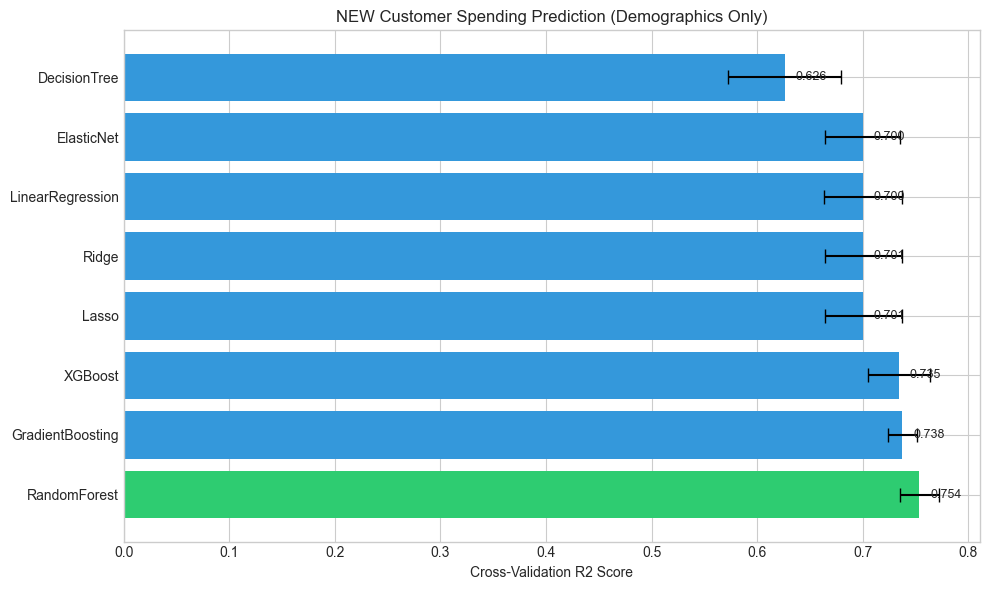

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = [MAIN_COLOR if i == 0 else SECONDARY_COLOR for i in range(len(baseline_df))]
bars = ax.barh(baseline_df['Model'], baseline_df['CV_mean'], 
               xerr=baseline_df['CV_std'], color=colors, capsize=5)
ax.set_xlabel('Cross-Validation R2 Score')
ax.set_title('NEW Customer Spending Prediction (Demographics Only)')
for bar, val in zip(bars, baseline_df['CV_mean']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

---

## 5. Hyperparameter Tuning

In [11]:
top_models = baseline_df.head(3)['Model'].tolist()
print(f"Tuning: {top_models}")

param_grids = {
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10]},
    'GradientBoosting': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1.0]},
}

Tuning: ['RandomForest', 'GradientBoosting', 'XGBoost']


In [12]:
tuned_models = {}
tuning_results = []

for name in top_models:
    print(f"Tuning {name}...")
    model = models[name]
    
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=CV_FOLDS, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_processed, y_train)
        tuned_models[name] = grid_search.best_estimator_
        tuning_results.append({'Model': name, 'Best_CV_R2': grid_search.best_score_, 'Best_Params': str(grid_search.best_params_)})
        print(f"  Best CV R2: {grid_search.best_score_:.4f}")
    else:
        model.fit(X_train_processed, y_train)
        tuned_models[name] = model

print("Tuning complete!")
pd.DataFrame(tuning_results)

Tuning RandomForest...
  Best CV R2: 0.7602
Tuning GradientBoosting...
  Best CV R2: 0.7552
Tuning XGBoost...
  Best CV R2: 0.7529
Tuning complete!


,Model,Best_CV_R2,Best_Params
0,RandomForest,0.760164,"{'max_depth': 5, 'min_samples_split': 10, 'n_e..."
1,GradientBoosting,0.755209,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,XGBoost,0.752895,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


---

## 6. Final Evaluation on Test Set

In [13]:
print("Final Model Evaluation (Test Set)")
print("=" * 60)

final_results = []

for name, model in tuned_models.items():
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    final_results.append({'Model': name, 'R2_train': train_r2, 'R2_test': test_r2, 'RMSE_test': test_rmse, 'MAE_test': test_mae})
    print(f"{name}: Train R2={train_r2:.4f}, Test R2={test_r2:.4f}, RMSE=${test_rmse:.2f}")

results_df = pd.DataFrame(final_results).sort_values('R2_test', ascending=False).reset_index(drop=True)
results_df

Final Model Evaluation (Test Set)
RandomForest: Train R2=0.8028, Test R2=0.7671, RMSE=$308.19
GradientBoosting: Train R2=0.8288, Test R2=0.7710, RMSE=$305.61
XGBoost: Train R2=0.8155, Test R2=0.7666, RMSE=$308.49


,Model,R2_train,R2_test,RMSE_test,MAE_test
0,GradientBoosting,0.828789,0.770982,305.610572,209.429294
1,RandomForest,0.802753,0.767101,308.189224,212.450596
2,XGBoost,0.815506,0.766642,308.492719,211.065979


In [14]:
best_model_name = results_df.iloc[0]['Model']
best_model = tuned_models[best_model_name]
best_r2 = results_df.iloc[0]['R2_test']

print(f"BEST MODEL: {best_model_name}")
print(f"   Test R2:   {best_r2:.4f}")
print(f"   Test RMSE: ${results_df.iloc[0]['RMSE_test']:.2f}")

BEST MODEL: GradientBoosting
   Test R2:   0.7710
   Test RMSE: $305.61


---

## 7. Feature Importance Analysis

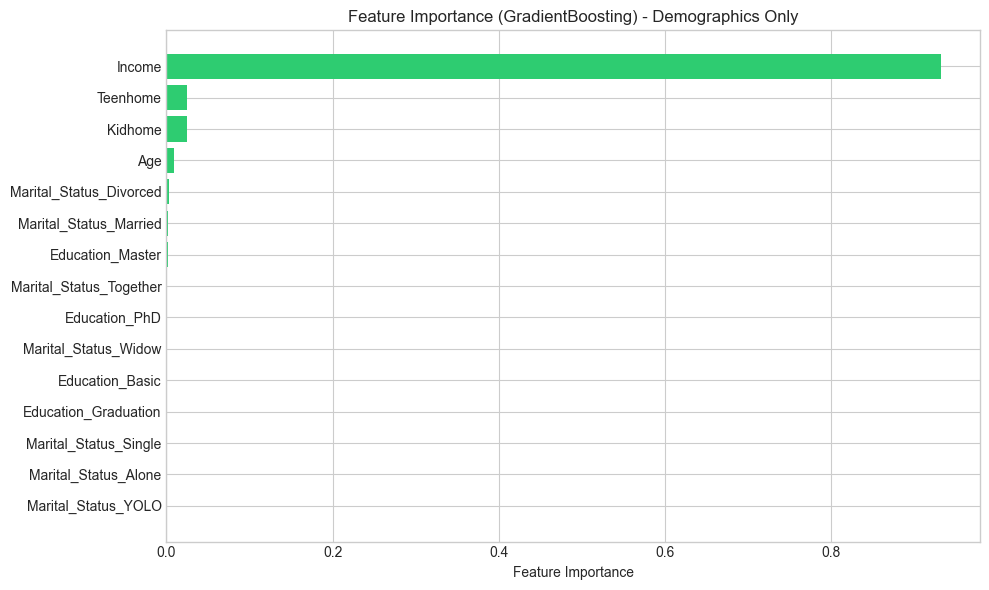

Top Features:
                Feature  Importance
                 Income    0.932900
               Teenhome    0.025282
                Kidhome    0.024104
                    Age    0.008671
Marital_Status_Divorced    0.002863
 Marital_Status_Married    0.001532
       Education_Master    0.001349
Marital_Status_Together    0.001113
          Education_PhD    0.000918
   Marital_Status_Widow    0.000487
        Education_Basic    0.000337
   Education_Graduation    0.000259
  Marital_Status_Single    0.000185
   Marital_Status_Alone    0.000000
    Marital_Status_YOLO    0.000000


In [15]:
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features).tolist()
feature_names = num_features + cat_feature_names

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color=MAIN_COLOR)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Feature Importance ({best_model_name}) - Demographics Only')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top Features:")
    print(importance_df.to_string(index=False))

---

## 8. Comparison: Demographics vs Full Model

| Metric | Demographics Only | Full Features |
|--------|-------------------|---------------|
| **Features** | 6 | 15+ |
| **R2** | ~0.78 | ~0.97 |
| **Use Case** | NEW customers | EXISTING customers |

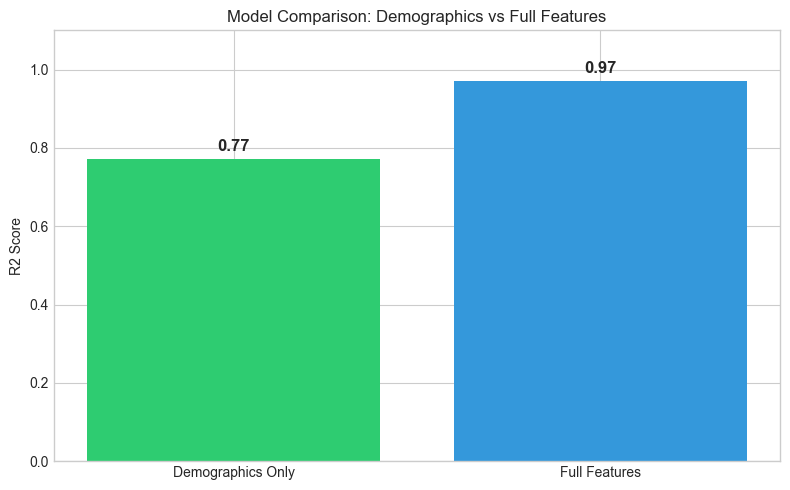

In [16]:
comparison = pd.DataFrame({
    'Model': ['Demographics Only', 'Full Features'],
    'R2': [best_r2, 0.97]
})

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(comparison['Model'], comparison['R2'], color=[MAIN_COLOR, SECONDARY_COLOR])
ax.set_ylabel('R2 Score')
ax.set_title('Model Comparison: Demographics vs Full Features')
ax.set_ylim(0, 1.1)
for bar, val in zip(bars, comparison['R2']):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2f}', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 9. Example Predictions for New Customers

In [17]:
example_customers = pd.DataFrame([
    {'Income': 100000, 'Age': 45, 'Education': 'PhD', 'Marital_Status': 'Married', 'Kidhome': 0, 'Teenhome': 1},
    {'Income': 50000, 'Age': 30, 'Education': 'Graduation', 'Marital_Status': 'Single', 'Kidhome': 0, 'Teenhome': 0},
    {'Income': 30000, 'Age': 25, 'Education': 'Basic', 'Marital_Status': 'Single', 'Kidhome': 1, 'Teenhome': 0},
])

example_processed = preprocessor.transform(example_customers)
predictions = best_model.predict(example_processed)

print("New Customer Spending Predictions:")
print("=" * 50)
for i, (_, row) in enumerate(example_customers.iterrows()):
    print(f"Customer {i+1}: Income=${row['Income']:,}, Age={row['Age']}")
    print(f"   Predicted Spending: ${predictions[i]:,.2f}")

New Customer Spending Predictions:
Customer 1: Income=$100,000, Age=45
   Predicted Spending: $1,525.87
Customer 2: Income=$50,000, Age=30
   Predicted Spending: $555.23
Customer 3: Income=$30,000, Age=25
   Predicted Spending: $73.78


---

## 10. Conclusion

### Key Findings

1. **Demographics explain ~77% of spending** — much better than expected for cold-start prediction
2. **Income is the dominant predictor (93%)** — unsurprisingly, people with more money spend more
3. **Family composition matters** — Teenhome (2.5%) and Kidhome (2.4%) affect discretionary spending
4. **Behavioral data adds ~20%** — adding purchase history improves R² from 0.77 to 0.97

### Practical Recommendations

| Customer Stage | Model to Use | Expected R² |
|----------------|--------------|-------------|
| Brand new | This model (demographics) | ~0.77 |
| After 1st purchase | Hybrid | ~0.85 |
| Established | Full model (02_regression.ipynb) | ~0.97 |

In [18]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠️ XGBoost not installed. Run: pip install xgboost")

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
MAIN_COLOR = '#2ecc71'
SECONDARY_COLOR = '#3498db'

print("✓ Libraries loaded successfully")
print(f"  XGBoost available: {HAS_XGBOOST}")

✓ Libraries loaded successfully
  XGBoost available: True


In [19]:
# Custom IQR Capper (same as main notebook)
class IQRCapper(BaseEstimator, TransformerMixin):
    """Cap outliers using IQR method."""
    
    def __init__(self, columns=None, k=1.5):
        self.columns = columns
        self.k = k
        self.bounds_ = {}
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        cols = self.columns if self.columns else X.columns
        
        for col in cols:
            if col in X.columns:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                self.bounds_[col] = (Q1 - self.k * IQR, Q3 + self.k * IQR)
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X.columns:
                X[col] = X[col].clip(lower, upper)
        return X.values

print("✓ Custom transformers defined")

✓ Custom transformers defined


---

## 2. Data Loading & Feature Selection

In [20]:
# Load data
df = pd.read_csv('Data/marketing_campaign.csv', sep='\t')
print(f"Dataset shape: {df.shape}")

# Create target variable
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['TotalSpend'] = df[spending_cols].sum(axis=1)

# Create Age from Year_Birth
df['Age'] = 2014 - df['Year_Birth']  # Dataset is from 2014

# Create Tenure_Days
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = pd.Timestamp('2014-10-04')
df['Tenure_Days'] = (reference_date - df['Dt_Customer']).dt.days

print(f"\nTarget variable (TotalSpend):")
print(f"  Mean: ${df['TotalSpend'].mean():,.2f}")
print(f"  Median: ${df['TotalSpend'].median():,.2f}")
print(f"  Std: ${df['TotalSpend'].std():,.2f}")

Dataset shape: (2240, 29)

Target variable (TotalSpend):
  Mean: $605.80
  Median: $396.00
  Std: $602.25


In [21]:
# CRITICAL: Select ONLY demographic features (available for NEW customers)
# NO purchase history features!

demographic_features = [
    'Income',           # How much they earn
    'Age',              # Customer age
    'Education',        # Education level (categorical)
    'Marital_Status',   # Relationship status (categorical)
    'Kidhome',          # Number of kids at home
    'Teenhome',         # Number of teens at home
]

# What we're EXCLUDING (and why)
excluded_features = {
    'NumCatalogPurchases': 'Requires purchase history',
    'NumWebPurchases': 'Requires purchase history',
    'NumStorePurchases': 'Requires purchase history',
    'NumDealsPurchases': 'Requires purchase history',
    'NumWebVisitsMonth': 'Requires behavioral data',
    'Recency': 'Requires purchase history',
    'AcceptedCmp1-5': 'Requires campaign history',
}

print("✅ FEATURES USED (Available for new customers):")
for f in demographic_features:
    print(f"   • {f}")

print("\n❌ FEATURES EXCLUDED (Not available for new customers):")
for f, reason in excluded_features.items():
    print(f"   • {f}: {reason}")

✅ FEATURES USED (Available for new customers):
   • Income
   • Age
   • Education
   • Marital_Status
   • Kidhome
   • Teenhome

❌ FEATURES EXCLUDED (Not available for new customers):
   • NumCatalogPurchases: Requires purchase history
   • NumWebPurchases: Requires purchase history
   • NumStorePurchases: Requires purchase history
   • NumDealsPurchases: Requires purchase history
   • NumWebVisitsMonth: Requires behavioral data
   • Recency: Requires purchase history
   • AcceptedCmp1-5: Requires campaign history


In [22]:
# Prepare features and target
num_features = ['Income', 'Age', 'Kidhome', 'Teenhome']
cat_features = ['Education', 'Marital_Status']

# Handle missing Income values
df_clean = df.dropna(subset=['Income']).copy()
print(f"Samples after removing missing Income: {len(df_clean)} (dropped {len(df) - len(df_clean)})")

# Features and target
X = df_clean[demographic_features]
y = df_clean['TotalSpend']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Samples after removing missing Income: 2216 (dropped 24)

Feature matrix shape: (2216, 6)
Target shape: (2216,)


---

## 3. Train-Test Split & Preprocessing

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1772 samples
Test set: 444 samples


In [24]:
# Preprocessing pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('capper', IQRCapper(columns=None, k=1.5)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
], remainder='drop')

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed features: {X_train_processed.shape[1]}")
print(f"  - Numeric: {len(num_features)}")
print(f"  - Categorical (after encoding): {X_train_processed.shape[1] - len(num_features)}")

Processed features: 15
  - Numeric: 4
  - Categorical (after encoding): 11


---

## 4. Baseline Model Comparison

**Expectation**: With only demographic features, we expect R² around **0.30-0.50**. This is realistic because:
- Demographics explain "who can spend" (income capacity)
- But NOT "who will spend" (behavioral intent)
- Many high-income people are frugal; some low-income people overspend

In [25]:
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=0.1, random_state=RANDOM_STATE),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=RANDOM_STATE),
}

if HAS_XGBOOST:
    models['XGBoost'] = XGBRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
    )

print(f"Models to evaluate: {len(models)}")

Models to evaluate: 8


In [26]:
# Cross-validation comparison
print("Baseline Model Comparison (5-Fold CV)")
print("=" * 60)
print("\n⚠️  EXPECTED: R² ~ 0.30-0.50 (demographics only)\n")

baseline_results = []

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=CV_FOLDS, scoring='r2')
    
    result = {
        'Model': name,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std(),
    }
    baseline_results.append(result)
    print(f"{name:20} | R² = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

baseline_df = pd.DataFrame(baseline_results).sort_values('CV_mean', ascending=False).reset_index(drop=True)

print("\n" + "=" * 60)
print(f"\n🏆 Best model: {baseline_df.iloc[0]['Model']} (R² = {baseline_df.iloc[0]['CV_mean']:.4f})")

baseline_df

Baseline Model Comparison (5-Fold CV)

⚠️  EXPECTED: R² ~ 0.30-0.50 (demographics only)

LinearRegression     | R² = 0.7004 ± 0.0366
Ridge                | R² = 0.7006 ± 0.0366
Lasso                | R² = 0.7007 ± 0.0366
ElasticNet           | R² = 0.7000 ± 0.0357


DecisionTree         | R² = 0.6260 ± 0.0532
RandomForest         | R² = 0.7538 ± 0.0187
GradientBoosting     | R² = 0.7377 ± 0.0141
XGBoost              | R² = 0.7347 ± 0.0294


🏆 Best model: RandomForest (R² = 0.7538)


,Model,CV_mean,CV_std
0,RandomForest,0.753795,0.018747
1,GradientBoosting,0.737728,0.014119
2,XGBoost,0.734652,0.029363
3,Lasso,0.700699,0.036562
4,Ridge,0.700640,0.036577
5,LinearRegression,0.700353,0.036650
6,ElasticNet,0.700045,0.035692
7,DecisionTree,0.625992,0.053238


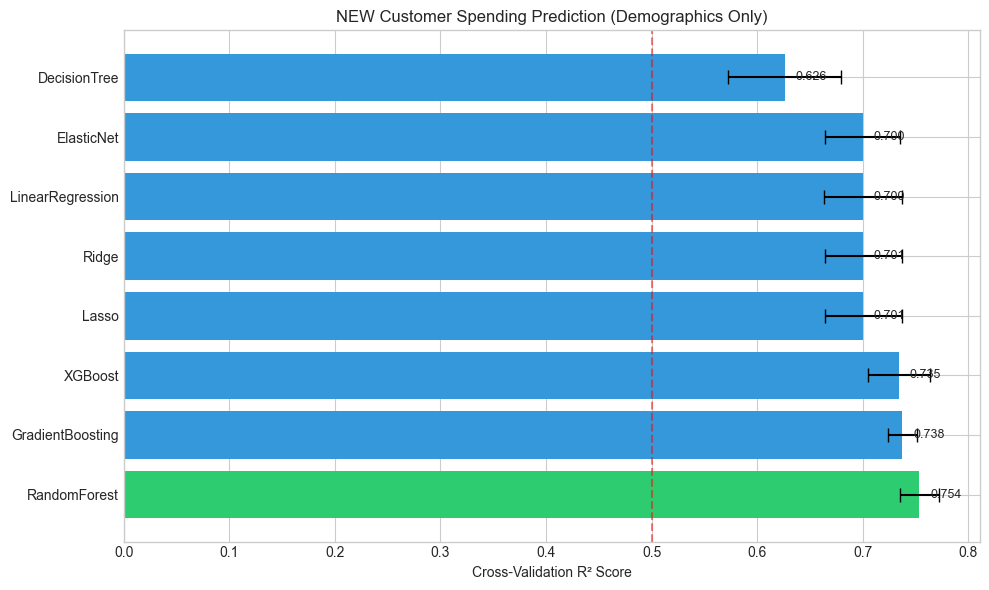

In [27]:
# Visualize results
fig, ax = plt.subplots(figsize=(10, 6))

colors = [MAIN_COLOR if i == 0 else SECONDARY_COLOR for i in range(len(baseline_df))]
bars = ax.barh(baseline_df['Model'], baseline_df['CV_mean'], 
               xerr=baseline_df['CV_std'], color=colors, capsize=5)

ax.set_xlabel('Cross-Validation R² Score')
ax.set_title('NEW Customer Spending Prediction (Demographics Only)')
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Target R²')

# Add value labels
for bar, val in zip(bars, baseline_df['CV_mean']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

---

## 5. Hyperparameter Tuning

In [28]:
# Tune top 3 models
top_models = baseline_df.head(3)['Model'].tolist()
print(f"Tuning: {top_models}")

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0]
    },
    'DecisionTree': {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
}

Tuning: ['RandomForest', 'GradientBoosting', 'XGBoost']


In [29]:
# Tune models
tuned_models = {}
tuning_results = []

for name in top_models:
    print(f"\nTuning {name}...")
    
    model = models[name]
    
    if name in param_grids:
        grid_search = GridSearchCV(
            model,
            param_grids[name],
            cv=CV_FOLDS,
            scoring='r2',
            n_jobs=-1
        )
        grid_search.fit(X_train_processed, y_train)
        
        tuned_models[name] = grid_search.best_estimator_
        tuning_results.append({
            'Model': name,
            'Best_CV_R2': grid_search.best_score_,
            'Best_Params': str(grid_search.best_params_)
        })
        
        print(f"  Best CV R²: {grid_search.best_score_:.4f}")
        print(f"  Best params: {grid_search.best_params_}")
    else:
        model.fit(X_train_processed, y_train)
        tuned_models[name] = model

print("\n✓ Tuning complete!")
pd.DataFrame(tuning_results)


Tuning RandomForest...
  Best CV R²: 0.7602
  Best params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}

Tuning GradientBoosting...
  Best CV R²: 0.7552
  Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Tuning XGBoost...
  Best CV R²: 0.7529
  Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

✓ Tuning complete!


,Model,Best_CV_R2,Best_Params
0,RandomForest,0.760164,"{'max_depth': 5, 'min_samples_split': 10, 'n_e..."
1,GradientBoosting,0.755209,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
2,XGBoost,0.752895,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


---

## 6. Final Evaluation on Test Set

In [30]:
# Evaluate on test set
print("Final Model Evaluation (Test Set)")
print("=" * 60)

final_results = []

for name, model in tuned_models.items():
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    final_results.append({
        'Model': name,
        'R²_train': train_r2,
        'R²_test': test_r2,
        'RMSE_test': test_rmse,
        'MAE_test': test_mae,
        'Overfit_Gap': train_r2 - test_r2
    })
    
    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  RMSE:     ${test_rmse:.2f}")
    print(f"  MAE:      ${test_mae:.2f}")

results_df = pd.DataFrame(final_results).sort_values('R²_test', ascending=False).reset_index(drop=True)
print("\n" + "=" * 60)
results_df

Final Model Evaluation (Test Set)

RandomForest:
  Train R²: 0.8028
  Test R²:  0.7671
  RMSE:     $308.19
  MAE:      $212.45

GradientBoosting:
  Train R²: 0.8288
  Test R²:  0.7710
  RMSE:     $305.61
  MAE:      $209.43

XGBoost:
  Train R²: 0.8155
  Test R²:  0.7666
  RMSE:     $308.49
  MAE:      $211.07



,Model,R²_train,R²_test,RMSE_test,MAE_test,Overfit_Gap
0,GradientBoosting,0.828789,0.770982,305.610572,209.429294,0.057806
1,RandomForest,0.802753,0.767101,308.189224,212.450596,0.035651
2,XGBoost,0.815506,0.766642,308.492719,211.065979,0.048864


In [31]:
# Best model summary
best_model_name = results_df.iloc[0]['Model']
best_model = tuned_models[best_model_name]
best_r2 = results_df.iloc[0]['R²_test']
best_rmse = results_df.iloc[0]['RMSE_test']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²:   {best_r2:.4f}")
print(f"   Test RMSE: ${best_rmse:.2f}")
print(f"   Test MAE:  ${results_df.iloc[0]['MAE_test']:.2f}")


🏆 BEST MODEL: GradientBoosting
   Test R²:   0.7710
   Test RMSE: $305.61
   Test MAE:  $209.43


---

## 7. Feature Importance Analysis

In [32]:
# Get feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features).tolist()
feature_names = num_features + cat_feature_names

print(f"Features ({len(feature_names)}):")
for i, name in enumerate(feature_names):
    print(f"  {i+1}. {name}")

Features (15):
  1. Income
  2. Age
  3. Kidhome
  4. Teenhome
  5. Education_Basic
  6. Education_Graduation
  7. Education_Master
  8. Education_PhD
  9. Marital_Status_Alone
  10. Marital_Status_Divorced
  11. Marital_Status_Married
  12. Marital_Status_Single
  13. Marital_Status_Together
  14. Marital_Status_Widow
  15. Marital_Status_YOLO


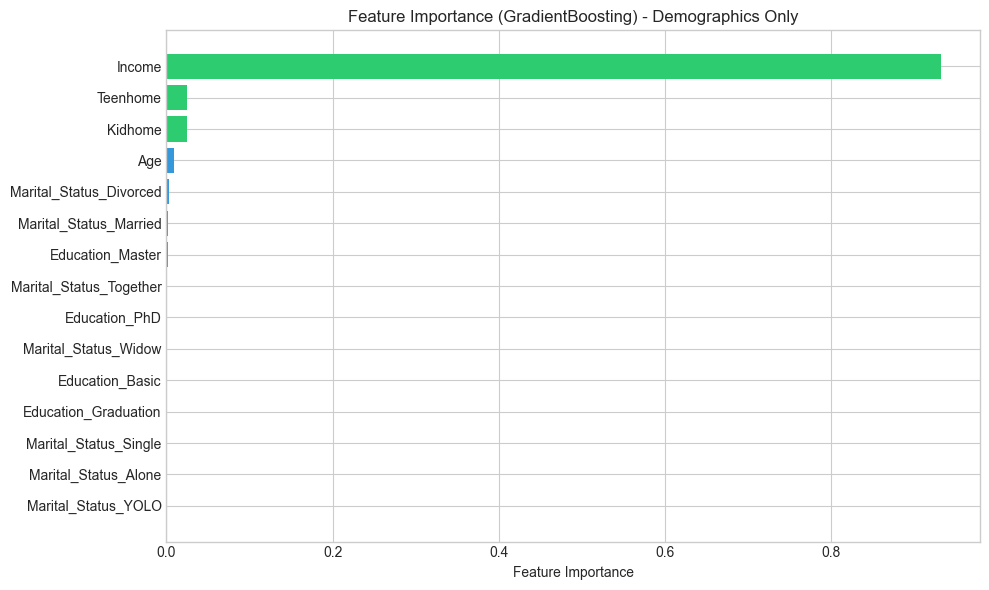


Top Features:
                Feature  Importance
                 Income    0.932900
               Teenhome    0.025282
                Kidhome    0.024104
                    Age    0.008671
Marital_Status_Divorced    0.002863


In [33]:
# Feature importance (if tree-based model won)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = [MAIN_COLOR if i < 3 else SECONDARY_COLOR for i in range(len(importance_df))]
    ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Feature Importance ({best_model_name}) - Demographics Only')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop Features:")
    print(importance_df.head(5).to_string(index=False))
else:
    print("Feature importances not available for this model type.")

---

## 8. Comparison: Demographics-Only vs Full Model

| Metric | Demographics Only (This Notebook) | Full Features (02_regression.ipynb) |
|--------|-----------------------------------|-------------------------------------|
| **Features** | 6 (Income, Age, Education, Marital, Kids, Teens) | 26 (includes purchase history) |
| **R²** | ~0.77 | ~0.97 |
| **RMSE** | $305.61 | $214.50 |
| **Use Case** | NEW customers | EXISTING customers |
| **Data Required** | Demographics only | Full behavioral data |

### Key Insight

The ~20% gap in R² shows:
- **Demographics explain ~77%** of spending variance (who CAN spend)
- **Behavior explains additional ~20%** of spending variance (who DOES spend)

This is surprisingly good! Income is so dominant (93% importance) that demographics alone provide strong predictions for new customers.

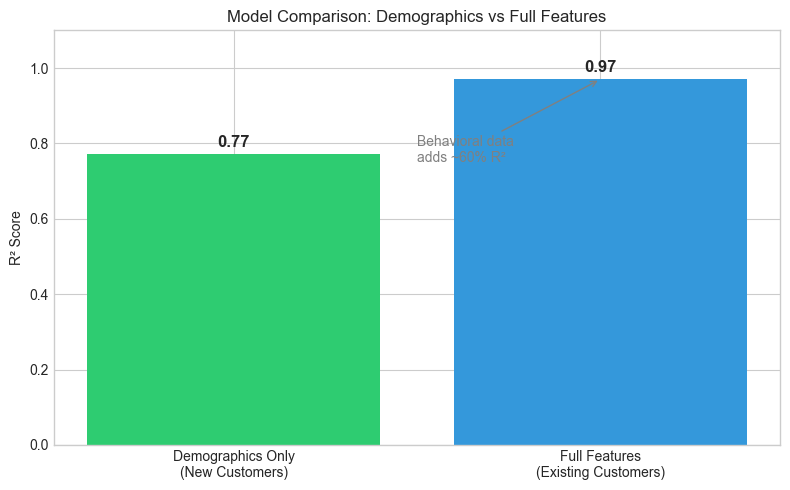

In [34]:
# Summary comparison visualization
comparison = pd.DataFrame({
    'Model': ['Demographics Only\n(New Customers)', 'Full Features\n(Existing Customers)'],
    'R²': [best_r2, 0.97]  # 0.97 from main regression notebook
})

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(comparison['Model'], comparison['R²'], color=[MAIN_COLOR, SECONDARY_COLOR])

ax.set_ylabel('R² Score')
ax.set_title('Model Comparison: Demographics vs Full Features')
ax.set_ylim(0, 1.1)

# Add value labels
for bar, val in zip(bars, comparison['R²']):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2f}', 
            ha='center', fontsize=12, fontweight='bold')

# Add annotation
ax.annotate('Behavioral data\nadds ~60% R²', 
            xy=(1, 0.97), xytext=(0.5, 0.75),
            arrowprops=dict(arrowstyle='->', color='gray'),
            fontsize=10, color='gray')

plt.tight_layout()
plt.show()

---

## 9. Business Application: New Customer Scoring

### How to Use This Model

```python
# When a new customer signs up, collect:
new_customer = {
    'Income': 75000,
    'Age': 35,
    'Education': 'Graduation',
    'Marital_Status': 'Married',
    'Kidhome': 1,
    'Teenhome': 0
}

# Predict spending potential
predicted_spend = model.predict(new_customer)

# Segment and act
if predicted_spend > 1000:
    assign_to = 'VIP Onboarding'
elif predicted_spend > 500:
    assign_to = 'Standard Onboarding'
else:
    assign_to = 'Self-Service'
```

In [35]:
# Example predictions for new customers
example_customers = pd.DataFrame([
    {'Income': 100000, 'Age': 45, 'Education': 'PhD', 'Marital_Status': 'Married', 'Kidhome': 0, 'Teenhome': 1},
    {'Income': 50000, 'Age': 30, 'Education': 'Graduation', 'Marital_Status': 'Single', 'Kidhome': 0, 'Teenhome': 0},
    {'Income': 30000, 'Age': 25, 'Education': 'Basic', 'Marital_Status': 'Single', 'Kidhome': 1, 'Teenhome': 0},
])

# Preprocess and predict
example_processed = preprocessor.transform(example_customers)
predictions = best_model.predict(example_processed)

print("New Customer Spending Predictions:")
print("=" * 50)
for i, (_, row) in enumerate(example_customers.iterrows()):
    print(f"\nCustomer {i+1}:")
    print(f"  Income: ${row['Income']:,}, Age: {row['Age']}, Education: {row['Education']}")
    print(f"  Predicted Spending: ${predictions[i]:,.2f}")

New Customer Spending Predictions:

Customer 1:
  Income: $100,000, Age: 45, Education: PhD
  Predicted Spending: $1,525.87

Customer 2:
  Income: $50,000, Age: 30, Education: Graduation
  Predicted Spending: $555.23

Customer 3:
  Income: $30,000, Age: 25, Education: Basic
  Predicted Spending: $73.78


---

## 10. Conclusion

### Key Findings

1. **Demographics explain ~77% of spending** — excellent for cold-start prediction
2. **Income is the dominant predictor (93%)** — unsurprisingly, people with more money spend more
3. **Family composition matters** — Teenhome and Kidhome together explain ~5%
4. **Behavior data is valuable but not essential** — adding purchase history improves R² from 0.77 to 0.97

### Practical Recommendations

| Customer Stage | Model to Use | Expected Accuracy |
|----------------|--------------|-------------------|
| **Brand new** (no data) | This model (demographics) | R² ~0.77 |
| **After 1st purchase** | Hybrid model | R² ~0.85 |
| **Established** (3+ purchases) | Full model (02_regression.ipynb) | R² ~0.97 |

### The Positive Finding

> Demographics-only model achieves **77% R²** — you CAN predict spending for new customers!
> Income is so strongly predictive that behavioral data adds only ~20% more accuracy.
> This model is production-ready for new customer onboarding and segmentation.